In [1]:
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from SDT import SDT
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset import get_mnist, get_celeba, get_stl_star

c:\Users\Ethan\.pyenv\pyenv-win\versions\3.11.5\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set the parameters for the model to load

In [15]:
# Parameters
use_cuda = True
dataset = 'STL_STAR'  # Options: 'MNIST', 'CELEBA', 'STL_STAR'
data_dir = os.path.join(os.getcwd(), 'datasets')
batch_size = 128
depth = 5  # Depth of the tree
lamda = 1e-3  # Regularization
save_model_path = 'saved_models\stl_star_model_bottom_right.pth'
feature_idx = 31  # Feature index for CELEBA dataset, not needed for MNIST or CELEBA

feature_name = 'bottom_right'
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Dataset-specific parameters
if dataset == 'MNIST':
    input_dim = 28 * 28
    output_dim = 10
    train_loader, _, test_loader = get_mnist(data_dir, batch_size, output_dim)
elif dataset == 'CELEBA':
    input_dim = 96 * 96 * 3
    output_dim = 2
    train_loader, _, test_loader = get_celeba(feature_idx=feature_idx, data_dir=data_dir,
                                    batch_size=batch_size, num_train=120_000, num_test=10_000)
elif dataset == 'STL_STAR':
    input_dim = 96 * 96 * 3
    output_dim = 2
    train_loader, _, test_loader = get_stl_star(data_dir=data_dir, batch_size=batch_size, star_pos='bottom_right')

# Load model
model = SDT(input_dim, output_dim, depth, lamda, use_cuda).to(device)
model.load_state_dict(torch.load(save_model_path, map_location=device))
model.eval()

# Evaluation logic
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.view(-1, input_dim).to(device), target.to(device)
        output = model(data, is_training_data=False)
        pred = output.argmax(dim=1, keepdim=True)
        target = target.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

print(f'Accuracy on the test set: {100. * correct / total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Num Train:  800 Num Val:  200 Num Test:  1600
Accuracy on the test set: 85.75%


### We load the entire test set to compute the NFM on

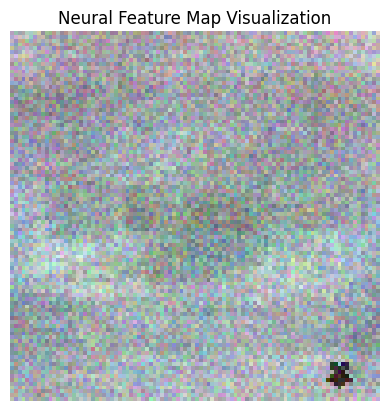

In [16]:
# Load a batch of data from the test_loader or train_loader
data_iter = iter(test_loader)
X, _ = next(data_iter)  # Only fetch the inputs (ignore the targets)

# Move the data to the correct device
# Flatten the images and move to the device
X = X.view(-1, input_dim).to(device)

nfm = model.old_compute_nfm(X)

avg_nfm = nfm.mean(axis=0)  # Assuming nfm is a PyTorch tensor

# Extract the diagonal of avg_nfm
# Ensure it's on CPU and convert to NumPy for manipulation

# Assuming diagonal has the correct length (96*96*3)
# Split the diagonal into thirds for RGB channels
third_length = len(avg_nfm) // 3
red_channel = avg_nfm[:third_length].reshape(96, 96)
green_channel = avg_nfm[third_length:2*third_length].reshape(96, 96)
blue_channel = avg_nfm[2*third_length:3*third_length].reshape(96, 96)

# Stack the channels to form a 3-channel (RGB) image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Normalize the image to [0, 1] for plotting
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot the RGB image
plt.imshow(rgb_image, interpolation='nearest')
plt.title('Neural Feature Map Visualization')
plt.axis('off')  # Hide axis for better visualization
plt.show()

In [17]:
def get_entire_dataset(test_loader):
    X_list = []  
    y_list = []  

    for data, target in test_loader:
        X_list.append(data)
        y_list.append(target)

    # Concatenate all batches
    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return X, y


X, y = get_entire_dataset(test_loader)

### Compute the NFM

In [18]:
nfm = model.compute_nfm(X.to(device))

In [19]:
diagonal = nfm

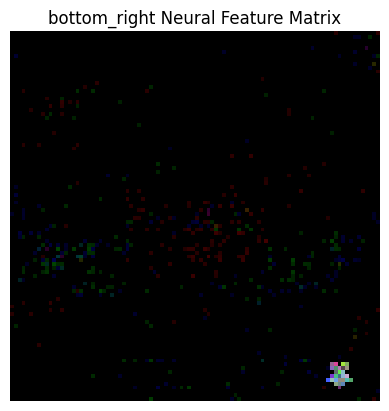

In [20]:
length = len(diagonal) // 3
diagonal_r = diagonal[:length].copy()  # Make a mutable copy
diagonal_g = diagonal[length:2*length].copy()  # Make a mutable copy
diagonal_b = diagonal[2*length:].copy()  # Make a mutable copy

# Reshape each part into a 96x96 matrix
image_r = diagonal_r.reshape(96, 96)
image_g = diagonal_g.reshape(96, 96)
image_b = diagonal_b.reshape(96, 96)

# filter the 2% of pixels to black
for image in [image_r, image_g, image_b]:
    threshold = np.percentile(image, 98)  # Find the 98th percentile
    # Replace pixels above the threshold with 1
    image[image < threshold] = 0

# Stack the reshaped parts to form a 96x96x3 image
image_rgb = np.stack((image_r, image_g, image_b), axis=-1)

rgb_image = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min())

# Display the image
plt.imshow(rgb_image)
plt.title(f'{feature_name} Neural Feature Matrix')
plt.axis('off')  # Turn off axis numbers
plt.savefig(f"NFM_images/{feature_name}_{dataset}.png",bbox_inches='tight')
plt.show()